# Mini-project HDDL — Conditional Variational Autoencoder (CVAE)

**Dataset :** Fashion-MNIST  
**Framework :** PyTorch  

## Objectifs du projet
- Comprendre et implémenter un **Conditional Variational Autoencoder (CVAE)**
- Comparer **plusieurs architectures CVAE** issues de la littérature scientifique
- Justifier les choix d’architecture, de loss et d’hyperparamètres
- Visualiser les performances (loss, espace latent)
- Générer **5 nouvelles images par classe** conditionnellement au label



      



## Plan du notebook

1. Mise en place de l’environnement  
2. Chargement et exploration des données  
3. Rappels théoriques : VAE vs CVAE  
4. Architectures CVAE testées (avec références)  
5. Implémentation des briques VAE  
6. Entraînement et comparaison des modèles  
7. Sélection du meilleur modèle  
8. Génération conditionnelle (5 images par classe)  
9. Analyse et conclusion




## 1 — Contexte scientifique et références

Le **Variational Autoencoder (VAE)** a été introduit par Kingma et Welling (2014) comme un modèle génératif probabiliste reposant sur l’optimisation variationnelle. Il permet d’apprendre une représentation latente continue des données en maximisant une borne inférieure de la vraisemblance (ELBO), composée d’un terme de reconstruction et d’un terme de régularisation via la divergence de Kullback-Leibler.

Le **Conditional Variational Autoencoder (CVAE)**, proposé par Sohn et al. (2015), étend ce cadre en introduisant une variable conditionnelle (par exemple une classe) dans l’encodeur et le décodeur. Ce conditionnement permet de contrôler explicitement la génération des données et de produire des échantillons correspondant à une condition donnée, ce qui est particulièrement pertinent pour des jeux de données étiquetés comme Fashion-MNIST.

Dans ce projet, nous nous appuyons sur ces travaux fondateurs pour évaluer et comparer plusieurs architectures de CVAE couramment utilisées pour la génération d’images de petite dimension (MNIST / Fashion-MNIST), en analysant leur comportement en termes de qualité de génération, de stabilité d’entraînement et de structuration de l’espace latent.

### Références

* **Kingma, D. P., & Welling, M. (2014).** *Auto-Encoding Variational Bayes.* International Conference on Learning Representations (ICLR).
  [https://arxiv.org/abs/1312.6114](https://arxiv.org/abs/1312.6114)
* **Sohn, K., Yan, X., & Lee, H. (2015).** *Learning Structured Output Representation using Deep Conditional Generative Models.* Advances in Neural Information Processing Systems (NeurIPS).
  [https://arxiv.org/abs/1506.02216](https://arxiv.org/abs/1506.02216)







## 2 — Environnement d’exécution et reproductibilité

Les expériences présentées dans ce notebook sont réalisées avec **PyTorch** sur une machine **Mac équipée d’Apple Silicon**. Lorsque cela est possible, le backend **MPS (Metal Performance Shaders)** est utilisé afin d’accélérer les calculs sur le GPU. À défaut, l’exécution est automatiquement basculée vers un GPU CUDA ou vers le CPU.

Afin de garantir la **reproductibilité des résultats** et de faciliter la comparaison entre les différentes architectures et configurations testées, une seed aléatoire est fixée pour les principales bibliothèques utilisées (Python, NumPy et PyTorch).





In [ ]:

import os, random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device = get_device()
device


device(type='mps')

In [29]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


## 3 — Dataset : Fashion-MNIST

Fashion-MNIST est un jeu de données composé de :
- 60 000 images d’entraînement
- 10 000 images de test
- Images en niveaux de gris de taille 28×28
- 10 classes (vêtements)

Les images sont normalisées dans l’intervalle [0,1], ce qui est adapté à une fonction de perte de reconstruction de type **Binary Cross-Entropy (BCE)**.


In [30]:
BATCH_SIZE = 128

transform = transforms.ToTensor()

train_ds = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_ds = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

len(train_ds), len(test_ds)


(60000, 10000)

## 4 — Sanity check des données

Avant d’entraîner les modèles, on vérifie :

### 4.1 Dimensions
- Images : **(B, 1, 28, 28)**
- Labels : **(B, )**

### 4.2 Valeurs des pixels
- Les pixels doivent être compris dans l’intervalle **[0,1]**

Cette vérification garantit la compatibilité avec l’architecture CVAE et la loss de reconstruction.


In [31]:
x, y = next(iter(train_loader))
x.shape, y.shape, x.min().item(), x.max().item(), y[:10].tolist()


(torch.Size([128, 1, 28, 28]),
 torch.Size([128]),
 0.0,
 1.0,
 [5, 7, 4, 7, 3, 8, 9, 5, 3, 1])

## Partie 4 — Rappels : VAE vs CVAE et fonction de perte

### 4.1 VAE (Variational Autoencoder)
Un VAE apprend un modèle génératif latent :
- **Encodeur** : q(z|x) = N(μ(x), σ²(x))
- **Décodeur** : p(x|z)

La loss correspond à l’ELBO (Evidence Lower Bound) :
- **Reconstruction** (fidélité des images reconstruites)
- **KL divergence** (régularisation vers N(0, I))

### 4.2 CVAE (Conditional VAE)
Le CVAE conditionne la génération par une information `y` (ici la classe).
On modélise :
- q(z | x, y)
- p(x | z, y)

=> On peut générer des images en choisissant `y` (classe) et en échantillonnant `z`.




## Partie 5 — Architectures CVAE testées et stratégies de conditionnement (Fashion-MNIST)

Dans le cadre de ce projet, les images étant de petite dimension (28×28), nous utilisons exclusivement des **architectures convolutionnelles (CNN)**, qui sont bien adaptées au traitement d’images et constituent le choix standard dans la littérature pour les VAE et CVAE appliqués à MNIST et Fashion-MNIST.
L’encodeur est composé de couches convolutionnelles suivies d’un petit réseau entièrement connecté produisant les paramètres ((\mu, \log\sigma^2)) de la distribution latente, conformément à l’architecture classique des VAE proposée par Kingma et Welling.

Nous évaluons ensuite différentes **stratégies de conditionnement par la classe**, afin d’analyser leur impact sur l’apprentissage et la qualité de la génération conditionnelle.

**Références générales :**
Kingma & Welling (2014), *Auto-Encoding Variational Bayes* ;
Sohn et al. (2015), *Conditional Variational Autoencoders*.

---

### Modèle 1 — CNN-CVAE avec concaténation tardive (late concatenation, one-hot)

Dans ce premier modèle, le conditionnement par la classe est introduit de manière simple via une concaténation tardive :

* l’encodeur applique des convolutions à l’image, puis concatène le vecteur one-hot de la classe avant la projection vers ((\mu, \log\sigma^2)),
* le décodeur concatène le vecteur latent (z) avec la classe avant la reconstruction.

Cette approche correspond à la formulation la plus directe du CVAE et constitue une **baseline** robuste et fréquemment utilisée.

**Référence :** Sohn et al. (2015).

---

### Modèle 2 — CNN-CVAE avec conditionnement précoce par embedding de classe

Dans ce modèle, la classe est injectée dès l’entrée de l’encodeur :

* chaque classe est transformée via une couche d’**embedding**,
* l’embedding est projeté sous forme de carte spatiale et concaténé à l’image d’entrée dans les canaux,
* l’encodeur reçoit ainsi l’information conditionnelle dès les premières convolutions.

Ce conditionnement précoce permet au réseau d’apprendre des représentations latentes explicitement dépendantes de la classe.

**Référence :** cadre CVAE de Sohn et al. (2015), pratiques courantes en conditionnement précoce.

---

### Modèle 3 — CNN-CVAE avec Conditional Batch Normalization (CBN)

Dans cette architecture, le conditionnement par la classe est intégré directement dans les couches internes du réseau :

* les paramètres de normalisation ((\gamma, \beta)) de la Batch Normalization sont prédits à partir de la classe,
* chaque classe module ainsi les activations convolutionnelles de manière spécifique.

Cette approche permet un conditionnement **feature-wise**, plus fin que la simple concaténation, et est largement utilisée dans les modèles génératifs conditionnels.

**Références :**
Sohn et al. (2015) pour le cadre CVAE ;
travaux sur la normalisation conditionnelle dans les réseaux profonds.

---

### Modèle 4 — CNN-CVAE avec FiLM (Feature-wise Linear Modulation)

Le mécanisme **FiLM** généralise le principe du conditionnement feature-wise :

* la classe est transformée en paramètres ((\gamma(y), \beta(y))),
* les cartes de features sont modulées par une transformation affine
  [
  \text{FiLM}(f) = \gamma(y) \odot f + \beta(y)
  ]

Ce type de modulation permet un contrôle expressif et continu des représentations internes du réseau.

**Référence :**
Perez et al. (2018), *FiLM: Visual Reasoning with a General Conditioning Layer*.

---

### Modèle 5 — ResNet-CVAE avec conditionnement feature-wise (CBN ou FiLM)

Enfin, nous testons une architecture plus profonde basée sur des **blocs résiduels (ResNet)** :

* les connexions résiduelles facilitent l’optimisation et améliorent la stabilité de l’entraînement,
* le conditionnement par la classe est intégré dans les blocs via CBN ou FiLM.

Ce modèle vise à combiner la stabilité des architectures résiduelles avec la flexibilité des mécanismes de conditionnement feature-wise.

**Références :**
He et al. (2016), *Deep Residual Learning for Image Recognition* ;
Perez et al. (2018) pour FiLM.





## Partie 6 — Standardisation de l’API (contrat commun)

Pour comparer plusieurs architectures sans modifier la boucle d’entraînement,
on impose un **contrat d’interface unique** :

- Entrées :
  - `x` : images de taille (B, 1, 28, 28)
  - `y_idx` : labels entiers (B,)
- Sorties :
  - `x_hat` : image reconstruite
  - `mu`, `logvar` : paramètres de la loi latente

Tous les modèles implémentent :
`x_hat, mu, logvar = model(x, y_idx)`


### 6.1 Encodage de la classe (y)

Selon les architectures, la classe peut être injectée de différentes façons :

- **One-hot** : concaténation tardive (late concat)
- **Embedding appris** : représentation compacte de la classe
- **Embedding spatial** : embedding répliqué en (D,H,W) pour concaténer aux canaux
- **Modulation feature-wise** : FiLM ou Conditional BatchNorm


In [45]:
import torch
import torch.nn.functional as F

N_CLASSES = 10
EMB_DIM = 16
IMG_H, IMG_W = 28, 28

def y_onehot_idx(y_idx, n_classes=N_CLASSES):
    return F.one_hot(y_idx, num_classes=n_classes).float()

def emb_to_map(y_emb, h=IMG_H, w=IMG_W):
    return y_emb[:, :, None, None].expand(-1, -1, h, w)


### 6.2 Briques VAE / CVAE

On définit ici les briques mathématiques communes :

- **Reparameterization trick** : permet l’apprentissage par rétropropagation
- **KL divergence** : régularisation vers N(0, I)
- **Reconstruction loss** : Binary Cross-Entropy (images normalisées)
- **Loss CVAE** : recon + β · KL (β-CVAE)


In [46]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std * eps

def kl_divergence(mu, logvar):
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, dim=1)

def recon_bce(x_hat, x):
    b = x.size(0)
    rec = F.binary_cross_entropy(x_hat, x, reduction="none")
    return rec.view(b, -1).sum(dim=1)

def cvae_loss(x_hat, x, mu, logvar, beta=1.0):
    rec = recon_bce(x_hat, x).mean()
    kl = kl_divergence(mu, logvar).mean()
    return rec + beta * kl, rec, kl


### 6.3 Wrapper d’API

Pour rendre la pipeline plus lisible, on définit un wrapper
qui matérialise le contrat d’interface commun.


In [47]:
def model_forward(model, x, y_idx):
    return model(x, y_idx)


## Partie 7 — Implémentation des architectures CVAE (CNN only)

On implémente maintenant les 5 architectures décrites en Partie 5.
Chaque modèle respecte strictement l’API commune définie précédemment.


### 7.1 Modules de conditionnement feature-wise

Deux méthodes permettent de conditionner directement les activations :

- **Conditional Batch Normalization (CBN)**
- **FiLM (Feature-wise Linear Modulation)**

Ces approches sont plus expressives qu’une simple concaténation.


In [48]:
import torch.nn as nn

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, n_classes=N_CLASSES, emb_dim=32):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.emb = nn.Embedding(n_classes, emb_dim)
        self.gamma = nn.Linear(emb_dim, num_features)
        self.beta  = nn.Linear(emb_dim, num_features)

    def forward(self, x, y_idx):
        h = self.bn(x)
        e = self.emb(y_idx)
        g = self.gamma(e).unsqueeze(-1).unsqueeze(-1)
        b = self.beta(e).unsqueeze(-1).unsqueeze(-1)
        return g * h + b

class FiLM2d(nn.Module):
    def __init__(self, num_features, n_classes=N_CLASSES, emb_dim=32):
        super().__init__()
        self.emb = nn.Embedding(n_classes, emb_dim)
        self.gamma = nn.Linear(emb_dim, num_features)
        self.beta  = nn.Linear(emb_dim, num_features)

    def forward(self, x, y_idx):
        e = self.emb(y_idx)
        g = self.gamma(e).unsqueeze(-1).unsqueeze(-1)
        b = self.beta(e).unsqueeze(-1).unsqueeze(-1)
        return g * x + b


### 7.2 Blocs convolutionnels de base

On définit un encodeur et un décodeur convolutionnels génériques,
réutilisés par plusieurs architectures.


In [49]:
class ConvEncoder(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.base = base
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(base, base*2, 3, stride=2, padding=1), nn.ReLU()
        )

    def forward(self, x):
        h = self.net(x)
        return h.view(x.size(0), -1)

class ConvDecoder(nn.Module):
    def __init__(self, out_ch=1, base=32):
        super().__init__()
        self.base = base
        self.net = nn.Sequential(
            nn.ConvTranspose2d(base*2, base, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(base, out_ch, 4, stride=2, padding=1), nn.Sigmoid()
        )

    def forward(self, h):
        return self.net(h)


### 7.3 Modèle 1 — CNN-CVAE avec concaténation tardive (one-hot)


In [ ]:
class CVAE_CNN_LateOneHot(nn.Module):
    def __init__(self, latent_dim, base=32, n_classes=N_CLASSES):
        super().__init__()
        self.n_classes = n_classes
        self.enc = ConvEncoder(in_ch=1, base=base)
        self.enc_fc = nn.Sequential(nn.Linear(base*2*7*7 + n_classes, 256), nn.ReLU())
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.dec_fc = nn.Sequential(nn.Linear(latent_dim + n_classes, 256), nn.ReLU(),
                                    nn.Linear(256, base*2*7*7), nn.ReLU())
        self.dec = ConvDecoder(out_ch=1, base=base)

    def forward(self, x, y_idx):
        y = y_onehot_idx(y_idx, self.n_classes).to(x.device)
        h = self.enc(x)
        h = self.enc_fc(torch.cat([h, y], dim=1))
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = reparameterize(mu, logvar)

        h = self.dec_fc(torch.cat([z, y], dim=1)).view(-1, 64, 7, 7)
        x_hat = self.dec(h)
        return x_hat, mu, logvar


### 7.4 Modèle 2 — CNN-CVAE avec embedding précoce (canaux)


In [ ]:
class CVAE_CNN_EarlyEmbedChannels(nn.Module):
    def __init__(self, latent_dim, base=32, n_classes=N_CLASSES, emb_dim=EMB_DIM):
        super().__init__()
        self.base = base  
        self.emb = nn.Embedding(n_classes, emb_dim)
        self.enc = ConvEncoder(in_ch=1 + emb_dim, base=base)

        self.enc_fc = nn.Sequential(
            nn.Linear(base * 2 * 7 * 7, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim + emb_dim, 256),
            nn.ReLU(),
            nn.Linear(256, base * 2 * 7 * 7),
            nn.ReLU()
        )
        self.dec = ConvDecoder(out_ch=1, base=base)

    def forward(self, x, y_idx):
        # embedding de classe
        y_emb = self.emb(y_idx.to(x.device))      # [B, D]
        ymap = emb_to_map(y_emb, 28, 28)          # [B, D, 28, 28]
        x_in = torch.cat([x, ymap], dim=1)        # [B, 1+D, 28, 28]

        # encodeur
        h = self.enc(x_in)
        h = self.enc_fc(h)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)

        # reparameterization
        z = reparameterize(mu, logvar)

        # décodeur
        h = self.dec_fc(torch.cat([z, y_emb], dim=1))
        h = h.view(-1, self.base * 2, 7, 7)
        x_hat = self.dec(h)

        return x_hat, mu, logvar


### 7.5 Modèle 3 — CNN-CVAE avec Conditional BatchNorm


In [53]:
class CVAE_CNN_CBN(nn.Module):
    def __init__(self, latent_dim, base=32, n_classes=N_CLASSES):
        super().__init__()
        self.c1 = nn.Conv2d(1, base, 3, stride=2, padding=1)
        self.bn1 = ConditionalBatchNorm2d(base, n_classes=n_classes)
        self.c2 = nn.Conv2d(base, base*2, 3, stride=2, padding=1)
        self.bn2 = ConditionalBatchNorm2d(base*2, n_classes=n_classes)

        self.enc_fc = nn.Sequential(nn.Linear(base*2*7*7, 256), nn.ReLU())
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.dec_fc = nn.Sequential(nn.Linear(latent_dim + n_classes, 256), nn.ReLU(),
                                    nn.Linear(256, base*2*7*7), nn.ReLU())
        self.dec = ConvDecoder(out_ch=1, base=base)
        self.n_classes = n_classes

    def forward(self, x, y_idx):
        h = F.relu(self.bn1(self.c1(x), y_idx))
        h = F.relu(self.bn2(self.c2(h), y_idx))
        h = h.view(x.size(0), -1)

        h = self.enc_fc(h)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = reparameterize(mu, logvar)

        y = y_onehot_idx(y_idx, self.n_classes).to(x.device)
        h = self.dec_fc(torch.cat([z, y], dim=1)).view(-1, 64, 7, 7)
        x_hat = self.dec(h)
        return x_hat, mu, logvar


### 7.6 Modèle 4 — CNN-CVAE avec FiLM


In [54]:
class CVAE_CNN_FiLM(nn.Module):
    def __init__(self, latent_dim, base=32, n_classes=N_CLASSES):
        super().__init__()
        self.c1 = nn.Conv2d(1, base, 3, stride=2, padding=1)
        self.f1 = FiLM2d(base, n_classes=n_classes)
        self.c2 = nn.Conv2d(base, base*2, 3, stride=2, padding=1)
        self.f2 = FiLM2d(base*2, n_classes=n_classes)

        self.enc_fc = nn.Sequential(nn.Linear(base*2*7*7, 256), nn.ReLU())
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.dec_fc = nn.Sequential(nn.Linear(latent_dim + n_classes, 256), nn.ReLU(),
                                    nn.Linear(256, base*2*7*7), nn.ReLU())
        self.dec = ConvDecoder(out_ch=1, base=base)
        self.n_classes = n_classes

    def forward(self, x, y_idx):
        h = F.relu(self.f1(self.c1(x), y_idx))
        h = F.relu(self.f2(self.c2(h), y_idx))
        h = h.view(x.size(0), -1)

        h = self.enc_fc(h)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = reparameterize(mu, logvar)

        y = y_onehot_idx(y_idx, self.n_classes).to(x.device)
        h = self.dec_fc(torch.cat([z, y], dim=1)).view(-1, 64, 7, 7)
        x_hat = self.dec(h)
        return x_hat, mu, logvar


### 7.7 Modèle 5 — ResNet-CVAE avec conditionnement


In [55]:
class ResBlockCBN(nn.Module):
    def __init__(self, c, n_classes=N_CLASSES):
        super().__init__()
        self.c1 = nn.Conv2d(c, c, 3, padding=1)
        self.b1 = ConditionalBatchNorm2d(c, n_classes=n_classes)
        self.c2 = nn.Conv2d(c, c, 3, padding=1)
        self.b2 = ConditionalBatchNorm2d(c, n_classes=n_classes)

    def forward(self, x, y_idx):
        h = F.relu(self.b1(self.c1(x), y_idx))
        h = self.b2(self.c2(h), y_idx)
        return F.relu(x + h)

class CVAE_ResNet_CBN(nn.Module):
    def __init__(self, latent_dim, base=32, n_classes=N_CLASSES):
        super().__init__()
        self.n_classes = n_classes

        self.down1 = nn.Conv2d(1, base, 3, stride=2, padding=1)     # 28->14
        self.bn1 = ConditionalBatchNorm2d(base, n_classes=n_classes)
        self.rb1 = ResBlockCBN(base, n_classes=n_classes)

        self.down2 = nn.Conv2d(base, base*2, 3, stride=2, padding=1) # 14->7
        self.bn2 = ConditionalBatchNorm2d(base*2, n_classes=n_classes)
        self.rb2 = ResBlockCBN(base*2, n_classes=n_classes)

        self.enc_fc = nn.Sequential(nn.Linear(base*2*7*7, 256), nn.ReLU())
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.dec_fc = nn.Sequential(nn.Linear(latent_dim + n_classes, 256), nn.ReLU(),
                                    nn.Linear(256, base*2*7*7), nn.ReLU())
        self.dec = ConvDecoder(out_ch=1, base=base)

    def forward(self, x, y_idx):
        h = F.relu(self.bn1(self.down1(x), y_idx))
        h = self.rb1(h, y_idx)
        h = F.relu(self.bn2(self.down2(h), y_idx))
        h = self.rb2(h, y_idx)

        h = h.view(x.size(0), -1)
        h = self.enc_fc(h)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = reparameterize(mu, logvar)

        y = y_onehot_idx(y_idx, self.n_classes).to(x.device)
        h = self.dec_fc(torch.cat([z, y], dim=1)).view(-1, 64, 7, 7)
        x_hat = self.dec(h)
        return x_hat, mu, logvar


## Partie 8 — Vérification de l’API (sanity check)

Avant l’entraînement, on vérifie que chaque modèle :
- accepte bien (x, y_idx)
- retourne des tenseurs de dimensions correctes


In [ ]:
# Cellule Code — Contract check 
def contract_check(make_model_fn, archs, latent_dim=10):
    x, y_idx = next(iter(train_loader))
    x = x.to(device)
    y_idx = y_idx.to(device)

    for arch in archs:
        m = make_model_fn(arch, latent_dim).to(device)
        x_hat, mu, logvar = model_forward(m, x, y_idx)

        assert x_hat.shape == x.shape, f"{arch}: x_hat shape {x_hat.shape} != {x.shape}"
        assert mu.shape == (x.size(0), latent_dim), f"{arch}: mu shape {mu.shape}"
        assert logvar.shape == (x.size(0), latent_dim), f"{arch}: logvar shape {logvar.shape}"

    print("Check passed")



## Partie 9 — Entraînement et comparaison des architectures

On entraîne chaque modèle avec la même procédure afin de comparer les architectures de manière équitable,
puis on évalue les performances sur le jeu de test.

### 9.1 — Objectif et métriques suivies

Pour chaque architecture CVAE, on suit :

- **Loss totale** = reconstruction + β·KL  
- **Reconstruction (BCE)** : à quel point le modèle reconstruit bien les images
- **KL divergence** : régularisation de l’espace latent

On compare surtout la **loss test finale**, mais on regarde aussi les **courbes reconstruction / KL**
pour repérer des comportements instables (par exemple un KL qui s’effondre trop vite).


In [57]:
# Cellule Code — Meter (logger simple)
class Meter:
    def __init__(self):
        self.s = 0.0
        self.n = 0
    def add(self, v, k=1):
        self.s += float(v) * k
        self.n += k
    @property
    def avg(self):
        return self.s / max(1, self.n)


## Partie 9.2 — Entraînement : une epoch (train)

On définit une fonction générique `train_one_epoch` qui fonctionne
avec n’importe quel modèle respectant l’API commune :
`x_hat, mu, logvar = model(x, y_idx)`.

Cette fonction réalise une passe complète sur le jeu d’entraînement
et agrège les différentes composantes de la loss.



In [58]:
# Cellule Code — train_one_epoch
def train_one_epoch(model, loader, optimizer, beta=1.0):
    model.train()
    m_total, m_rec, m_kl = Meter(), Meter(), Meter()

    for x, y_idx in loader:
        x = x.to(device)
        y_idx = y_idx.to(device)

        optimizer.zero_grad(set_to_none=True)

        x_hat, mu, logvar = model_forward(model, x, y_idx)
        loss, rec, kl = cvae_loss(x_hat, x, mu, logvar, beta=beta)

        loss.backward()
        optimizer.step()

        bs = x.size(0)
        m_total.add(loss.item(), bs)
        m_rec.add(rec.item(), bs)
        m_kl.add(kl.item(), bs)

    return {"loss": m_total.avg, "rec": m_rec.avg, "kl": m_kl.avg}


## Partie 9.3 — Évaluation : une epoch (test)

Même principe que pour l’entraînement, mais sans calcul de gradient.
Cette fonction permet d’estimer l’ELBO sur le jeu de test.



In [59]:
# Cellule Code — eval_one_epoch
@torch.no_grad()
def eval_one_epoch(model, loader, beta=1.0):
    model.eval()
    m_total, m_rec, m_kl = Meter(), Meter(), Meter()

    for x, y_idx in loader:
        x = x.to(device)
        y_idx = y_idx.to(device)

        x_hat, mu, logvar = model_forward(model, x, y_idx)
        loss, rec, kl = cvae_loss(x_hat, x, mu, logvar, beta=beta)

        bs = x.size(0)
        m_total.add(loss.item(), bs)
        m_rec.add(rec.item(), bs)
        m_kl.add(kl.item(), bs)

    return {"loss": m_total.avg, "rec": m_rec.avg, "kl": m_kl.avg}


## Partie 9.4 — Fonction `fit` : entraînement complet + historique

On entraîne pendant `epochs` et on stocke l’historique :
- train_loss, train_rec, train_kl
- test_loss, test_rec, test_kl


In [60]:
# Cellule Code — fit
def fit(model, train_loader, test_loader, epochs=10, lr=1e-3, beta=1.0):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {
        "train_loss": [], "train_rec": [], "train_kl": [],
        "test_loss": [],  "test_rec": [],  "test_kl": []
    }

    for ep in range(1, epochs + 1):
        tr = train_one_epoch(model, train_loader, opt, beta=beta)
        te = eval_one_epoch(model, test_loader, beta=beta)

        hist["train_loss"].append(tr["loss"])
        hist["train_rec"].append(tr["rec"])
        hist["train_kl"].append(tr["kl"])
        hist["test_loss"].append(te["loss"])
        hist["test_rec"].append(te["rec"])
        hist["test_kl"].append(te["kl"])

        print(
            f"Epoch {ep:02d}/{epochs} | "
            f"train {tr['loss']:.1f} (rec {tr['rec']:.1f}, kl {tr['kl']:.1f}) | "
            f"test {te['loss']:.1f} (rec {te['rec']:.1f}, kl {te['kl']:.1f})"
        )

    return model, hist


## Partie 9.5 — Visualisation des courbes

On trace séparément :
- loss totale
- reconstruction (BCE)
- KL divergence


In [61]:
# Cellule Code — plot_history
import matplotlib.pyplot as plt

def plot_history(hist, title=""):
    epochs = range(1, len(hist["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, hist["train_loss"], label="train_loss")
    plt.plot(epochs, hist["test_loss"], label="test_loss")
    plt.legend()
    plt.title(title + " | Total loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

    plt.figure()
    plt.plot(epochs, hist["train_rec"], label="train_rec")
    plt.plot(epochs, hist["test_rec"], label="test_rec")
    plt.legend()
    plt.title(title + " | Reconstruction (BCE)")
    plt.xlabel("epoch")
    plt.ylabel("recon")
    plt.show()

    plt.figure()
    plt.plot(epochs, hist["train_kl"], label="train_kl")
    plt.plot(epochs, hist["test_kl"], label="test_kl")
    plt.legend()
    plt.title(title + " | KL divergence")
    plt.xlabel("epoch")
    plt.ylabel("kl")
    plt.show()


## Partie 9.6 — Grille d’expériences (comparaison automatique)

On teste une grille simple :

- architecture ∈ `ARCHS`
- latent_dim ∈ {2, 10}
- β ∈ {1, 2}

Critère de sélection : plus faible `test_loss` finale.


In [ ]:
# paramètres de la grille
LATENT_DIMS_TO_TRY = [2, 10]
BETAS_TO_TRY = [1.0, 2.0]
EPOCHS_GRID = 8      
LR = 1e-3


In [ ]:
# runner
def run_experiments(archs, latent_dims, betas, epochs=10, lr=1e-3):
    results = []
    best = None

    for arch in archs:
        for ld in latent_dims:
            for beta in betas:
                print("\n" + "="*90)
                print(f"ARCH={arch} | latent_dim={ld} | beta={beta}")

                model = make_model(arch, ld)
                model, hist = fit(model, train_loader, test_loader,
                                  epochs=epochs, lr=lr, beta=beta)

                final = hist["test_loss"][-1]
                row = {
                    "arch": arch, "latent_dim": ld, "beta": beta,
                    "test_loss": final, "model": model, "hist": hist
                }
                results.append(row)

                if best is None or final < best["test_loss"]:
                    best = row

    return results, best


## Partie 9.7 — Lancement de la comparaison + sélection du meilleur

On lance la grille, puis on récupère :
- la meilleure architecture
- son historique
- ses courbes


In [ ]:
# Exécution
results, best = run_experiments(
    archs=ARCHS,
    latent_dims=LATENT_DIMS_TO_TRY,
    betas=BETAS_TO_TRY,
    epochs=EPOCHS_GRID,
    lr=LR
)

best["arch"], best["latent_dim"], best["beta"], best["test_loss"]



ARCH=cnn_late_onehot | latent_dim=2 | beta=1.0
Epoch 01/8 | train 281.1 (rec 276.9, kl 4.3) | test 261.9 (rec 257.0, kl 4.9)
Epoch 02/8 | train 258.1 (rec 253.2, kl 4.9) | test 258.0 (rec 252.9, kl 5.0)
Epoch 03/8 | train 255.7 (rec 250.7, kl 5.0) | test 256.9 (rec 251.8, kl 5.0)
Epoch 04/8 | train 254.5 (rec 249.5, kl 5.1) | test 255.6 (rec 250.5, kl 5.1)
Epoch 05/8 | train 253.7 (rec 248.7, kl 5.1) | test 254.9 (rec 249.9, kl 5.0)
Epoch 06/8 | train 253.2 (rec 248.1, kl 5.1) | test 254.6 (rec 249.6, kl 5.0)
Epoch 07/8 | train 252.7 (rec 247.6, kl 5.1) | test 254.4 (rec 249.2, kl 5.2)
Epoch 08/8 | train 252.4 (rec 247.3, kl 5.1) | test 253.9 (rec 249.0, kl 4.9)

ARCH=cnn_late_onehot | latent_dim=2 | beta=2.0
Epoch 01/8 | train 284.9 (rec 277.7, kl 3.6) | test 263.7 (rec 255.5, kl 4.1)
Epoch 02/8 | train 260.9 (rec 252.7, kl 4.1) | test 261.9 (rec 253.7, kl 4.1)
Epoch 03/8 | train 259.2 (rec 251.0, kl 4.1) | test 260.2 (rec 251.8, kl 4.2)
Epoch 04/8 | train 258.2 (rec 250.0, kl 4.1) |

('cnn_late_onehot', 10, 1.0, 238.09268913574218)

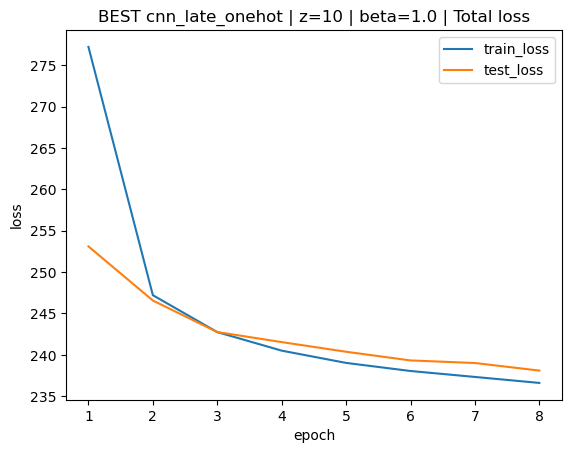

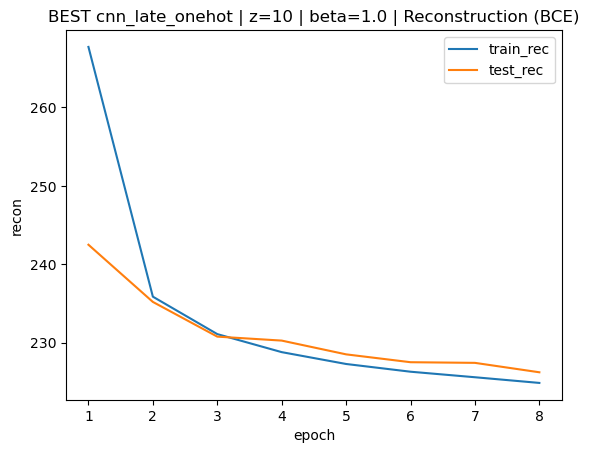

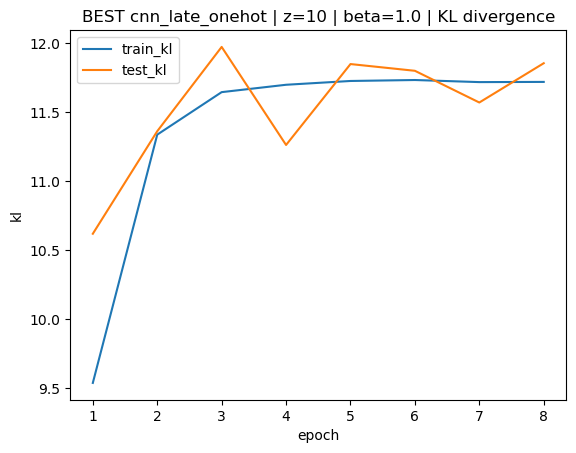

In [ ]:
# Courbes du meilleur modèle
plot_history(best["hist"], title=f"BEST {best['arch']} | z={best['latent_dim']} | beta={best['beta']}")


## Partie 9.8 — Classement Top-5 (pour discussion)

on affiche un top-5 des configurations
afin de discuter :
- l’impact du conditionnement (late vs early vs FiLM/CBN)
- l’impact de `latent_dim`
- l’impact de β


In [ ]:
# Top 5 configs
top = sorted(results, key=lambda r: r["test_loss"])[:5]
[(r["arch"], r["latent_dim"], r["beta"], round(r["test_loss"], 2)) for r in top]


[('cnn_late_onehot', 10, 1.0, 238.09),
 ('cnn_early_emb_ch', 10, 1.0, 238.38),
 ('resnet_cbn', 10, 1.0, 238.75),
 ('cnn_cbn', 10, 1.0, 238.75),
 ('cnn_film', 10, 1.0, 239.83)]

## Partie 10 — Sélection finale (Top-3) + ré-entraînement

On retient les **3 meilleures configurations** d’après la `test_loss` :

1) `cnn_late_onehot`  (z=10, β=1.0)  — 238.09  
2) `cnn_early_emb_ch` (z=10, β=1.0)  — 238.38  
3) `resnet_cbn`       (z=10, β=1.0)  — 238.75  

Objectif :
- Ré-entraîner chacune un peu plus longtemps (stabilisation)
- Comparer à nouveau sur test
- Garder le meilleur modèle final pour la génération conditionnelle.


In [ ]:
# Définition du Top-3 
TOP3 = [
    ("cnn_late_onehot", 10, 1.0),
    ("cnn_early_emb_ch", 10, 1.0),
    ("resnet_cbn", 10, 1.0),
]

### 10.1 Ré-entraînement final (epochs plus élevés)

Sur MPS, on peut viser par exemple :
- 20 epochs (ou 15 si c’est trop long)
- même LR au départ (1e-3), puis option : baisser à 5e-4 si besoin.


In [ ]:
# hyperparams final training
EPOCHS_FINAL = 15
LR_FINAL = 1e-3


In [ ]:
# Entraînement final des 3 meilleurs
final_runs = []

for arch, ld, beta in TOP3:
    print("\n" + "="*95)
    print(f"FINAL TRAIN | arch={arch} | z={ld} | beta={beta}")

    model = make_model(arch, ld)
    model, hist = fit(model, train_loader, test_loader,
                      epochs=EPOCHS_FINAL, lr=LR_FINAL, beta=beta)

    test_final = hist["test_loss"][-1]
    final_runs.append({
        "arch": arch, "latent_dim": ld, "beta": beta,
        "test_loss": test_final, "model": model, "hist": hist
    })

# Meilleur sur ce "final training"
final_best = sorted(final_runs, key=lambda r: r["test_loss"])[0]
final_best["arch"], final_best["latent_dim"], final_best["beta"], final_best["test_loss"]



FINAL TRAIN | arch=cnn_late_onehot | z=10 | beta=1.0
Epoch 01/15 | train 276.8 (rec 267.4, kl 9.3) | test 253.8 (rec 243.6, kl 10.2)
Epoch 02/15 | train 248.6 (rec 238.0, kl 10.6) | test 247.2 (rec 236.2, kl 11.1)
Epoch 03/15 | train 244.3 (rec 233.5, kl 10.8) | test 244.8 (rec 234.2, kl 10.6)
Epoch 04/15 | train 242.1 (rec 231.3, kl 10.8) | test 242.9 (rec 232.1, kl 10.8)
Epoch 05/15 | train 240.8 (rec 230.0, kl 10.8) | test 241.7 (rec 230.7, kl 10.9)
Epoch 06/15 | train 239.7 (rec 228.9, kl 10.8) | test 240.9 (rec 230.1, kl 10.8)
Epoch 07/15 | train 238.9 (rec 228.1, kl 10.8) | test 240.2 (rec 229.5, kl 10.7)
Epoch 08/15 | train 238.2 (rec 227.5, kl 10.7) | test 239.7 (rec 228.9, kl 10.8)
Epoch 09/15 | train 237.7 (rec 227.1, kl 10.7) | test 239.5 (rec 228.7, kl 10.9)
Epoch 10/15 | train 237.3 (rec 226.7, kl 10.6) | test 239.0 (rec 228.4, kl 10.6)
Epoch 11/15 | train 236.8 (rec 226.2, kl 10.6) | test 238.7 (rec 227.9, kl 10.8)
Epoch 12/15 | train 236.5 (rec 225.8, kl 10.7) | test 23

('cnn_early_emb_ch', 10, 1.0, 235.90611811523436)

### 10.2 Courbes des 3 meilleurs (pour discussion rapport)

On trace les courbes train/test pour chaque architecture afin de discuter :
- stabilité
- reconstruction vs régularisation (KL)


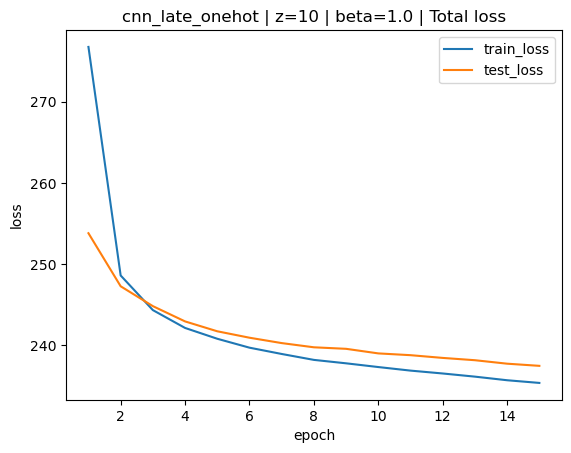

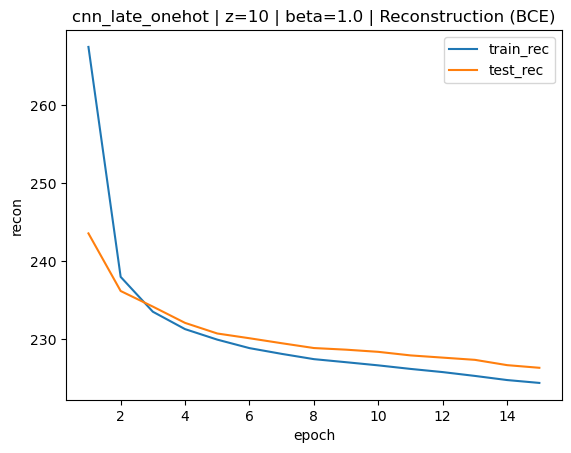

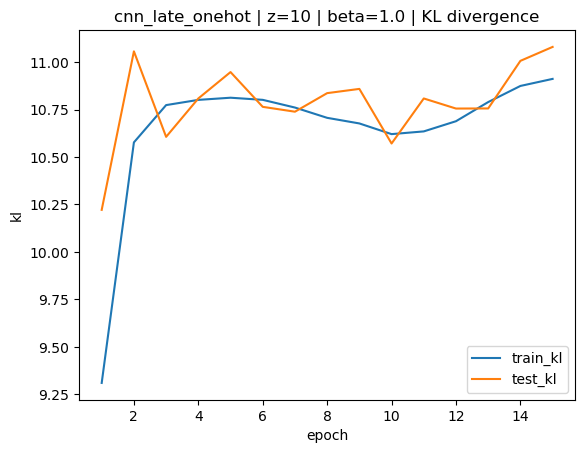

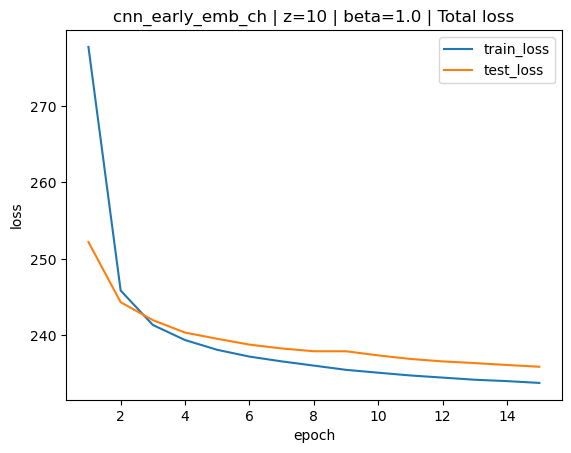

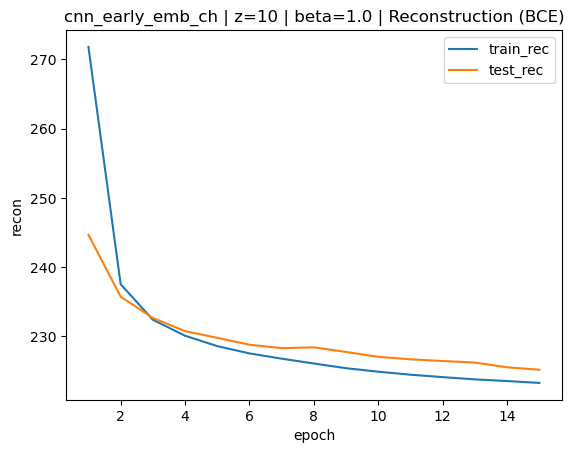

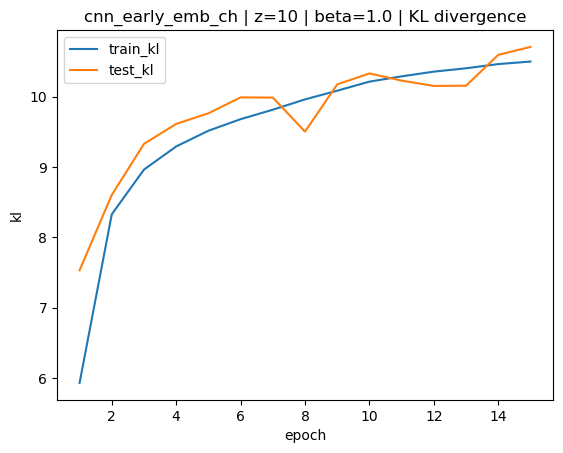

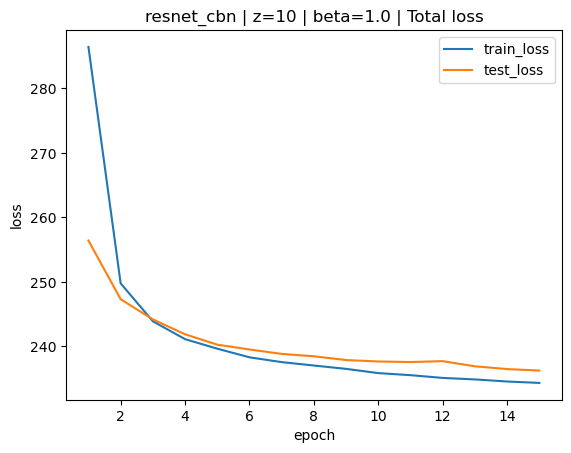

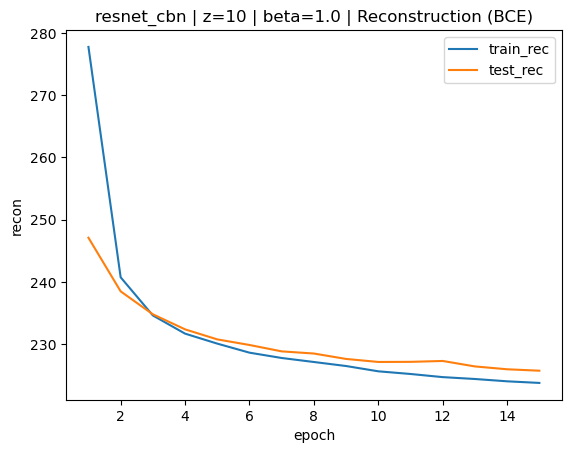

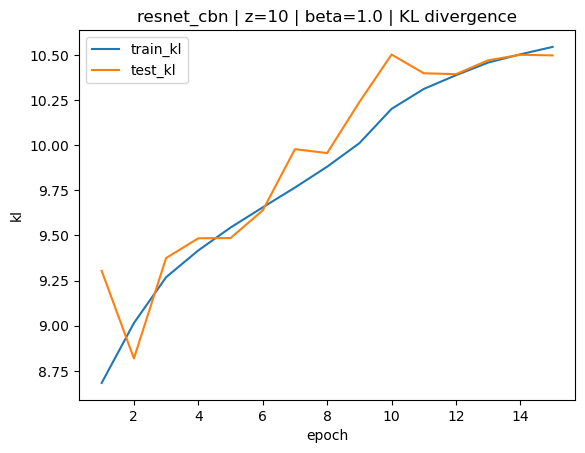

In [ ]:
# Plots des 3 runs finaux
for r in final_runs:
    plot_history(r["hist"], title=f"{r['arch']} | z={r['latent_dim']} | beta={r['beta']}")


### 10.3 Sélection du meilleur modèle final

Après ré-entraînement des 3 meilleures architectures, on sélectionne la configuration
qui minimise la `test_loss` finale.

**Meilleur modèle retenu :** `cnn_early_emb_ch` avec z=10 et β=1.0


In [ ]:
# Paramètres du meilleur modèle
BEST_ARCH = "cnn_early_emb_ch"
BEST_Z = 10
BEST_BETA = 1.0

best_model = final_best["model"].to(device)
best_model.eval()


CVAE_CNN_EarlyEmbedChannels(
  (emb): Embedding(10, 16)
  (enc): ConvEncoder(
    (net): Sequential(
      (0): Conv2d(17, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
  )
  (enc_fc): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=10, bias=True)
  (dec_fc): Sequential(
    (0): Linear(in_features=26, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3136, bias=True)
    (3): ReLU()
  )
  (dec): ConvDecoder(
    (net): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): Sigmoid()
    )
  )
)

## Partie 11 — Génération conditionnelle (5 images par classe)

On utilise directement le **meilleur modèle déjà entraîné** (top-3, 15 epochs).
Ici, le meilleur est :

- `cnn_early_emb_ch`
- z = 10
- β = 1.0

Objectif : générer **5 images par classe** (50 images au total).


In [ ]:

BEST_ARCH = final_best["arch"]         
BEST_BETA = final_best["beta"]        

best_model = final_best["model"].to(device)
best_model.eval()

BEST_ARCH, BEST_Z, BEST_BETA


('cnn_early_emb_ch', 10, 1.0)

### 11.1 Fonction de génération (spécifique à `cnn_early_emb_ch`)

La classe est injectée via un embedding :
- y_emb = Embedding(y)
- on décode à partir de concat(z, y_emb)


In [89]:
@torch.no_grad()
def generate_early_emb(model, y_idx, n_samples=1, latent_dim=10, device=None):
    if device is None:
        device = next(model.parameters()).device

    model.eval()

    y = torch.full((n_samples,), int(y_idx), dtype=torch.long, device=device)
    z = torch.randn(n_samples, latent_dim, device=device)

    y_emb = model.emb(y)  # [B, EMB_DIM]
    h = model.dec_fc(torch.cat([z, y_emb], dim=1))
    h = h.view(-1, model.base * 2, 7, 7)
    x_hat = model.dec(h)  # [B,1,28,28]
    return x_hat


### 11.2 Génération : 5 images par classe


In [91]:
samples = []

for y in range(N_CLASSES):
    x_gen = generate_early_emb(
        best_model,
        y_idx=y,
        n_samples=5,
        latent_dim=BEST_Z,
        device=device
    )
    samples.append(x_gen.cpu())

samples = torch.cat(samples, dim=0)  # [50,1,28,28]
samples.shape


torch.Size([50, 1, 28, 28])

### 11.4 Visualisation des images générées

On affiche les images générées sous forme de grille :
- 10 lignes (une par classe)
- 5 colonnes (réalisations différentes)


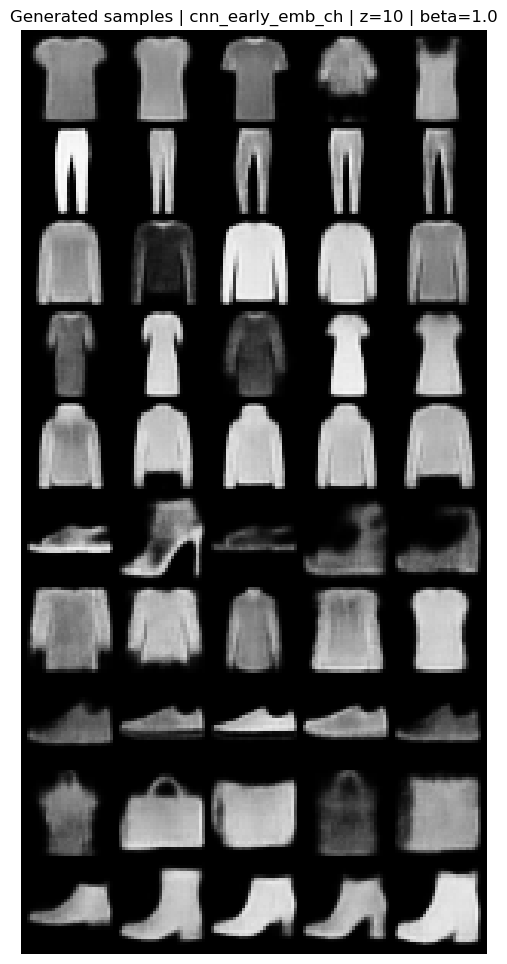

In [92]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

grid = make_grid(samples, nrow=5, padding=2)

plt.figure(figsize=(8, 12))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.title(f"Generated samples | {BEST_ARCH} | z={BEST_Z} | beta={BEST_BETA}")
plt.show()


## Partie 12 — Discussion et conclusion

Le CVAE conditionnel avec **injection précoce du label** (embedding en canaux)
donne les meilleurs résultats sur Fashion-MNIST.

L’injection du label dès les premières couches convolutionnelles
guide efficacement l’extraction de features pertinentes.

Les différences entre architectures restent modérées,
ce qui est cohérent avec la simplicité relative du dataset.

Enfin, β = 1.0 offre un bon compromis entre qualité de reconstruction
et régularisation de l’espace latent.

